In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys, os, time, math
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import jcTrajectory_CP as cellTraj
import h5py
import pickle
import subprocess
import umap
import pyemma.coordinates as coor
import scipy
from csaps import csaps
import string
from joblib import dump, load
from datetime import date
#from deeptime.clustering import KMeans
from sklearn.cluster import KMeans

In [2]:
# Trajectory Length for morphodynamical trajectory analysis
trajl = 40
#os.environ['OMP_NUM_THREADS'] = '1'; os.environ['MKL_NUM_THREADS'] = '1'
today = date.today()
date2day = today.strftime("%b%d-%Y")
sysName = 'LI204601_P'
figid = sysName+'_tlen'+str(trajl)+'_'+date2day
conditions = ['A1','A2','A3','A4','A5','C1','C2','C3'] # LIGANDS (CONDITIONS)
tmSet = ['OSM1','EGF1','EGF+TGFB1','TGFB1','PBS1','OSM+EGF+TGFB','OSM+EGF','OSM+TGFB']
nConditions = len(tmSet) # Total number of Ligand Conditions
# Indices for the ligands
inds_tmSet = [i for i in range(nConditions)]
inds_tmSet = np.array(inds_tmSet).astype(int)
# Number of field of views during live-cell microscopy imaging 
nfovs = 2
fovs = [i for i in range(1, nfovs + 1)]
fovs = np.array(fovs).astype(int)
dateSet = ['']
pathSet = ['/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/jcPipelineTest/']
# This is required if there are more than one imaging sets, otherwise redundant 
imagingSet = [0 for i in range(nConditions)]
modelList = [None]*(nfovs*(nConditions))
modelList_conditions = np.zeros(nfovs*(nConditions)).astype(int)

In [3]:
i = 0
icond = 0
for cond in conditions:
    for fov in fovs:
        modelList_conditions[i] = icond
        modelList[i] = pathSet[imagingSet[icond]]+sysName+'_'+cond+'_'+str(fov)+dateSet[imagingSet[icond]]
        #print("Models: ",modelList[i])
        i = i + 1
    icond = icond + 1

nmodels = len(modelList)
modelSet = [None]*nmodels
indgood_models = np.array([]).astype(int)

for i in range(nmodels):
    try:
        objFile = modelList[i]+'.obj'
        objFileHandler = open(objFile,'rb')
        modelSet[i] = pickle.load(objFileHandler)
        print('loaded '+'../'+objFile[32:]+' with '+str(modelSet[i].cells_indSet.size)+' cells')
        objFileHandler.close()
        test = len(modelSet[i].linSet)
        indgood_models = np.append(indgood_models,i)
    except:
        print("ERROR in reading *.obj files")
        sys.exit(0)

loaded ../LI204601_INCUCYTE/segsCellPose/jcPipelineTest/LI204601_P_A1_1.obj with 49883 cells
loaded ../LI204601_INCUCYTE/segsCellPose/jcPipelineTest/LI204601_P_A1_2.obj with 74080 cells
loaded ../LI204601_INCUCYTE/segsCellPose/jcPipelineTest/LI204601_P_A2_1.obj with 52018 cells
loaded ../LI204601_INCUCYTE/segsCellPose/jcPipelineTest/LI204601_P_A2_2.obj with 97552 cells
loaded ../LI204601_INCUCYTE/segsCellPose/jcPipelineTest/LI204601_P_A3_1.obj with 47405 cells
loaded ../LI204601_INCUCYTE/segsCellPose/jcPipelineTest/LI204601_P_A3_2.obj with 68133 cells
loaded ../LI204601_INCUCYTE/segsCellPose/jcPipelineTest/LI204601_P_A4_1.obj with 41109 cells
loaded ../LI204601_INCUCYTE/segsCellPose/jcPipelineTest/LI204601_P_A4_2.obj with 63343 cells
loaded ../LI204601_INCUCYTE/segsCellPose/jcPipelineTest/LI204601_P_A5_1.obj with 58123 cells
loaded ../LI204601_INCUCYTE/segsCellPose/jcPipelineTest/LI204601_P_A5_2.obj with 67843 cells
loaded ../LI204601_INCUCYTE/segsCellPose/jcPipelineTest/LI204601_P_C1_

In [4]:
# Total number of frames (image snapshots) in one condition per FOVs
nframes = 193 
cellnumber_stdSet = np.ones(nmodels)*np.inf
# range of frame indices where cell numbers are higher: ~70-98%
sframe = 70.*nframes/100.; sframe = math.ceil(sframe)
eframe = 98.5*nframes/100.; eframe = math.ceil(eframe)
cellnumber_frames = np.arange(sframe, eframe).astype(int)
cellnumber_std_cut = .50 # This was set to 0.10 by Jeremy 
frames = np.arange(nframes)
# Abscissas at which smoothing will be done using CSAPS package
abSmooth = np.linspace(frames[0], frames[-1], 10000)

#plt.clf()
#plt.figure(figsize = (8, 7))

with open('cellNumbers.dat', 'w', encoding = 'utf-8') as fp: # PRINT cell numbers in a file for each model
     for i in indgood_models:
        ncells = np.zeros(nframes)
        ncells_smooth = np.zeros_like(ncells)
        for iS in range(nframes):
            ncells[iS]=np.sum(modelSet[i].cells_frameSet==iS)
            fp.write(str(ncells[iS])+"\t")
            fp.write("\n")
        # Cubic Spline Approximation (CSAPS) to smoothen the data
        splfov = csaps(frames, ncells/ncells[0], abSmooth, smooth = 0.98) # Scaled by ncells[0] to avoid large numbers
        ncells_smooth = splfov*ncells[0] # smoothened cell numbers reverse scaled back to original
        cellnumber_std = np.std(ncells[cellnumber_frames] - 
                                ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
        cellnumber_stdSet[i] = cellnumber_std # Standard Deviation in Cell Numbers
        #print("cellnumber_stdSet[",i,"] = ", cellnumber_std)
        #plt.plot(ncells/ncells[0], color = colModels[i], label = capModels[i])
        #plt.plot(ncells, color = colModels[i], label = capModels[i])
        #plt.plot(ncells/ncells[0]); plt.pause(.5)

In [5]:
indhigh_std = np.where(cellnumber_stdSet > cellnumber_std_cut)[0]
indgood_models = np.setdiff1d(indgood_models, indhigh_std)
#indgood_models = np.setdiff1d(indgood_models, np.array([51]).astype(int)) #missing comdx for EGF0_4

# get cell counts
nf = len(tmSet)
inds_tmSet_models = np.zeros(nmodels).astype(int)
inds_imagingSet_models = np.zeros(nmodels).astype(int)
i = 0
icond = 0
for cond in conditions:
    for fov in fovs:
        inds_tmSet_models[i] = inds_tmSet[icond]
        inds_imagingSet_models[i] = imagingSet[icond]
        i = i + 1
    icond = icond + 1

# If NAN exist in model sets that are used in the analysis, replace them with zeros 
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        modelSet[i].Xf[np.isnan(modelSet[i].Xf)] = 0.0

nfeat_com = 3
Xf_com0 = np.zeros((0, nfeat_com))
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf_com0 = np.append(Xf_com0,modelSet[i].Xf_com, axis = 0)

av_dx = np.nanmean(Xf_com0[:, 0])
std_dx = np.nanstd(Xf_com0[:, 0])
for i in indgood_models:
    modelSet[i].Xf_com[:, 0] = (modelSet[i].Xf_com[:, 0] - av_dx)/std_dx

In [6]:
wctm = cellTraj.Trajectory() # import Trajectory object 

nfeat = modelSet[indgood_models[0]].Xf.shape[1]
Xf = np.zeros((0, nfeat))
indtreatment = np.array([])
indcellSet = np.array([])
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf = np.append(Xf, modelSet[i].Xf, axis = 0)
        indtreatment = np.append(indtreatment, i*np.ones(modelSet[i].Xf.shape[0]))
        indcellSet = np.append(indcellSet, modelSet[i].cells_indSet)

indtreatment = indtreatment.astype(int)
indcellSet = indcellSet.astype(int)

In [7]:
varCutOff = 0.95
# we will use the sklearn package (intended for ease of use over performance/scalability)
from sklearn.decomposition import PCA 
# n_components specifies the number of principal components to extract from the covariance matrix
#@@@@@@ Variance Cut Offs and their corresponding features after dimensional reduction using PCA @@@@@@
#varCutOffs = [0.95, 0.96, 0.97, 0.98, 0.985, 0.99, 0.992, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999]
#nFeatures = [5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 20, 27]
pca = PCA(n_components = varCutOff)
pca.fit(Xf) # builds the covariance matrix and "fits" the principal components
Xpca = pca.transform(Xf) # transforms the data into the pca representation
#print("Number of PCs to keep: ",Xpca.shape[1])

Number of PCs to keep:  5


In [8]:
wctm.Xpca = Xpca
wctm.pca = pca
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        indsf = np.where(indtreatment == i)[0]
        modelSet[i].Xpca = Xpca[indsf, :]

indgood_models = indgood_models[np.where(inds_imagingSet_models[indgood_models] == 0)[0]]

self = wctm
wctm.trajl = trajl
all_trajSet = [None]*nmodels
for i in indgood_models:
    modelSet[i].get_unique_trajectories()
    all_trajSet[i] = modelSet[i].trajectories.copy()

tracked cell 49878, 24 tracks, 49800 left
tracked cell 49785, 27 tracks, 48300 left
tracked cell 48191, 1 tracks, 44400 left
tracked cell 47980, 108 tracks, 44200 left
tracked cell 47736, 1 tracks, 44100 left
tracked cell 47020, 2 tracks, 43600 left
tracked cell 46953, 2 tracks, 43500 left
tracked cell 46337, 1 tracks, 42500 left
tracked cell 46281, 4 tracks, 42200 left
tracked cell 46262, 2 tracks, 42000 left
tracked cell 45650, 1 tracks, 41500 left
tracked cell 43934, 1 tracks, 40100 left
tracked cell 43782, 7 tracks, 40000 left
tracked cell 43544, 1 tracks, 39800 left
tracked cell 42567, 2 tracks, 38500 left
tracked cell 40938, 5 tracks, 37400 left
tracked cell 39619, 6 tracks, 36400 left
tracked cell 39467, 3 tracks, 36300 left
tracked cell 38458, 1 tracks, 35800 left
tracked cell 38226, 1 tracks, 35700 left
tracked cell 37587, 10 tracks, 35200 left
tracked cell 37312, 1 tracks, 35000 left
tracked cell 36434, 1 tracks, 34600 left
tracked cell 35959, 9 tracks, 34300 left
tracked cel

tracked cell 21505, 1 tracks, 20700 left
tracked cell 21449, 1 tracks, 20600 left
tracked cell 21428, 1 tracks, 20500 left
tracked cell 21360, 1 tracks, 20400 left
tracked cell 21215, 2 tracks, 20000 left
tracked cell 21016, 3 tracks, 18300 left
tracked cell 20977, 16 tracks, 18000 left
tracked cell 20231, 2 tracks, 17300 left
tracked cell 19478, 1 tracks, 17000 left
tracked cell 18933, 3 tracks, 16600 left
tracked cell 18254, 3 tracks, 16400 left
tracked cell 17502, 3 tracks, 15900 left
tracked cell 16776, 2 tracks, 15600 left
tracked cell 16131, 1 tracks, 15000 left
tracked cell 15984, 1 tracks, 14700 left
tracked cell 15946, 1 tracks, 14600 left
tracked cell 15738, 1 tracks, 13300 left
tracked cell 15310, 5 tracks, 12200 left
tracked cell 14416, 10 tracks, 11500 left
tracked cell 13885, 3 tracks, 11100 left
tracked cell 12018, 2 tracks, 9500 left
tracked cell 11591, 13 tracks, 8900 left
tracked cell 10343, 3 tracks, 8100 left
tracked cell 10186, 1 tracks, 8000 left
tracked cell 9742

tracked cell 91266, 3 tracks, 82500 left
tracked cell 89914, 1 tracks, 81400 left
tracked cell 87597, 1 tracks, 79400 left
tracked cell 86190, 2 tracks, 78400 left
tracked cell 85672, 1 tracks, 78000 left
tracked cell 85543, 1 tracks, 77900 left
tracked cell 85381, 1 tracks, 77800 left
tracked cell 84858, 5 tracks, 77400 left
tracked cell 84492, 9 tracks, 77100 left
tracked cell 84005, 9 tracks, 76700 left
tracked cell 82173, 2 tracks, 75200 left
tracked cell 80909, 1 tracks, 74300 left
tracked cell 80469, 1 tracks, 74000 left
tracked cell 80274, 1 tracks, 73900 left
tracked cell 79957, 8 tracks, 73500 left
tracked cell 79411, 20 tracks, 72700 left
tracked cell 79364, 1 tracks, 72600 left
tracked cell 78880, 1 tracks, 72200 left
tracked cell 78110, 14 tracks, 71300 left
tracked cell 77135, 1 tracks, 70600 left
tracked cell 76697, 2 tracks, 70300 left
tracked cell 76243, 1 tracks, 69700 left
tracked cell 75919, 3 tracks, 69500 left
tracked cell 75434, 3 tracks, 69100 left
tracked cell 7

tracked cell 3945, 8 tracks, 3600 left
tracked cell 3769, 7 tracks, 3300 left
tracked cell 3569, 2 tracks, 2600 left
tracked cell 3484, 7 tracks, 2300 left
tracked cell 3097, 5 tracks, 1800 left
tracked cell 2506, 1 tracks, 1600 left
tracked cell 2113, 1 tracks, 1500 left
tracked cell 1885, 1 tracks, 1400 left
tracked cell 1240, 1 tracks, 1100 left
tracked cell 1149, 4 tracks, 1000 left
tracked cell 1042, 2 tracks, 800 left
tracked cell 957, 2 tracks, 600 left
tracked cell 859, 1 tracks, 400 left
tracked cell 815, 3 tracks, 300 left
tracked cell 756, 1 tracks, 200 left
tracked cell 446, 2 tracks, 100 left
tracked cell 16, 1 tracks, 0 left
tracked cell 47395, 52 tracks, 47100 left
tracked cell 47379, 4 tracks, 46600 left
tracked cell 47300, 32 tracks, 44100 left
tracked cell 46185, 5 tracks, 40400 left
tracked cell 44938, 22 tracks, 39400 left
tracked cell 44220, 40 tracks, 38600 left
tracked cell 43390, 1 tracks, 38100 left
tracked cell 42743, 14 tracks, 37900 left
tracked cell 41689, 

tracked cell 21670, 1 tracks, 20300 left
tracked cell 21401, 1 tracks, 20000 left
tracked cell 21234, 5 tracks, 19900 left
tracked cell 20643, 1 tracks, 19600 left
tracked cell 20416, 3 tracks, 19500 left
tracked cell 20244, 4 tracks, 19400 left
tracked cell 20049, 1 tracks, 19300 left
tracked cell 19630, 8 tracks, 19100 left
tracked cell 19007, 2 tracks, 18300 left
tracked cell 18802, 2 tracks, 18000 left
tracked cell 18661, 1 tracks, 17800 left
tracked cell 18136, 3 tracks, 17300 left
tracked cell 17390, 1 tracks, 17000 left
tracked cell 16924, 2 tracks, 16800 left
tracked cell 16828, 1 tracks, 16700 left
tracked cell 16581, 1 tracks, 16300 left
tracked cell 16519, 1 tracks, 16200 left
tracked cell 16468, 1 tracks, 16100 left
tracked cell 16423, 1 tracks, 16000 left
tracked cell 16261, 1 tracks, 15800 left
tracked cell 16120, 1 tracks, 15600 left
tracked cell 15964, 1 tracks, 15500 left
tracked cell 15810, 1 tracks, 15400 left
tracked cell 15644, 2 tracks, 14800 left
tracked cell 143

tracked cell 38768, 4 tracks, 37300 left
tracked cell 38742, 16 tracks, 37200 left
tracked cell 38516, 2 tracks, 36500 left
tracked cell 38137, 1 tracks, 36300 left
tracked cell 37792, 9 tracks, 36100 left
tracked cell 37684, 1 tracks, 35800 left
tracked cell 37564, 1 tracks, 35600 left
tracked cell 37463, 5 tracks, 35500 left
tracked cell 37039, 1 tracks, 34500 left
tracked cell 35102, 4 tracks, 33600 left
tracked cell 34767, 25 tracks, 33400 left
tracked cell 34540, 1 tracks, 33300 left
tracked cell 34354, 2 tracks, 33100 left
tracked cell 34219, 25 tracks, 32900 left
tracked cell 33798, 1 tracks, 32700 left
tracked cell 33724, 16 tracks, 32500 left
tracked cell 33528, 2 tracks, 32000 left
tracked cell 33501, 1 tracks, 31900 left
tracked cell 33412, 9 tracks, 31700 left
tracked cell 33402, 1 tracks, 31600 left
tracked cell 33273, 15 tracks, 30900 left
tracked cell 31865, 1 tracks, 29600 left
tracked cell 31480, 8 tracks, 29400 left
tracked cell 30825, 2 tracks, 29000 left
tracked cel

tracked cell 818, 1 tracks, 500 left
tracked cell 706, 3 tracks, 300 left
tracked cell 637, 3 tracks, 200 left
tracked cell 9, 1 tracks, 0 left
tracked cell 67804, 5 tracks, 67100 left
tracked cell 67626, 2 tracks, 65200 left
tracked cell 67312, 1 tracks, 64300 left
tracked cell 67221, 8 tracks, 64200 left
tracked cell 67159, 2 tracks, 64000 left
tracked cell 66627, 2 tracks, 63600 left
tracked cell 66287, 2 tracks, 63300 left
tracked cell 65957, 1 tracks, 63100 left
tracked cell 64967, 1 tracks, 62400 left
tracked cell 64243, 1 tracks, 61700 left
tracked cell 63603, 31 tracks, 61200 left
tracked cell 62969, 1 tracks, 60600 left
tracked cell 62912, 1 tracks, 60500 left
tracked cell 62805, 1 tracks, 60100 left
tracked cell 62682, 6 tracks, 59900 left
tracked cell 62237, 4 tracks, 59300 left
tracked cell 61153, 2 tracks, 58300 left
tracked cell 60768, 2 tracks, 58100 left
tracked cell 60614, 1 tracks, 58000 left
tracked cell 60489, 1 tracks, 57900 left
tracked cell 59929, 1 tracks, 57300

tracked cell 25948, 7 tracks, 24900 left
tracked cell 25792, 2 tracks, 24800 left
tracked cell 25644, 12 tracks, 24600 left
tracked cell 24974, 8 tracks, 24200 left
tracked cell 24588, 1 tracks, 23900 left
tracked cell 24026, 1 tracks, 23000 left
tracked cell 23013, 1 tracks, 22500 left
tracked cell 22681, 2 tracks, 22300 left
tracked cell 22457, 3 tracks, 22100 left
tracked cell 22389, 6 tracks, 22000 left
tracked cell 21876, 2 tracks, 21700 left
tracked cell 21768, 2 tracks, 21500 left
tracked cell 21395, 1 tracks, 21200 left
tracked cell 21250, 1 tracks, 21100 left
tracked cell 21108, 2 tracks, 20900 left
tracked cell 21014, 2 tracks, 20800 left
tracked cell 20828, 2 tracks, 20700 left
tracked cell 20731, 1 tracks, 20600 left
tracked cell 20619, 1 tracks, 20400 left
tracked cell 20565, 2 tracks, 20300 left
tracked cell 20507, 2 tracks, 20200 left
tracked cell 20433, 1 tracks, 20100 left
tracked cell 20194, 1 tracks, 19900 left
tracked cell 20011, 2 tracks, 19700 left
tracked cell 19

tracked cell 39235, 66 tracks, 34700 left
tracked cell 38413, 8 tracks, 34200 left
tracked cell 38233, 1 tracks, 34100 left
tracked cell 37316, 1 tracks, 33600 left
tracked cell 37064, 12 tracks, 33500 left
tracked cell 35931, 1 tracks, 32300 left
tracked cell 35754, 2 tracks, 31900 left
tracked cell 34968, 2 tracks, 30700 left
tracked cell 34429, 1 tracks, 30300 left
tracked cell 34206, 2 tracks, 30200 left
tracked cell 34013, 1 tracks, 30100 left
tracked cell 33367, 2 tracks, 29800 left
tracked cell 32427, 1 tracks, 29300 left
tracked cell 32236, 9 tracks, 29200 left
tracked cell 31642, 16 tracks, 28300 left
tracked cell 31597, 5 tracks, 28200 left
tracked cell 31443, 2 tracks, 27800 left
tracked cell 30871, 10 tracks, 26500 left
tracked cell 30203, 10 tracks, 26100 left
tracked cell 29629, 1 tracks, 25800 left
tracked cell 29185, 2 tracks, 25500 left
tracked cell 28864, 2 tracks, 25300 left
tracked cell 27798, 1 tracks, 24400 left
tracked cell 27153, 41 tracks, 23800 left
tracked ce

tracked cell 34391, 7 tracks, 32800 left
tracked cell 34313, 1 tracks, 32700 left
tracked cell 34078, 1 tracks, 32500 left
tracked cell 33835, 7 tracks, 32300 left
tracked cell 33572, 2 tracks, 32100 left
tracked cell 33172, 2 tracks, 32000 left
tracked cell 32227, 1 tracks, 31300 left
tracked cell 32071, 3 tracks, 31200 left
tracked cell 31355, 8 tracks, 30800 left
tracked cell 31229, 1 tracks, 30700 left
tracked cell 30796, 1 tracks, 30100 left
tracked cell 30687, 1 tracks, 30000 left
tracked cell 30380, 2 tracks, 28700 left
tracked cell 30083, 5 tracks, 28000 left
tracked cell 29776, 7 tracks, 27700 left
tracked cell 28867, 2 tracks, 26600 left
tracked cell 28465, 3 tracks, 26100 left
tracked cell 27910, 4 tracks, 25500 left
tracked cell 27753, 1 tracks, 25400 left
tracked cell 26669, 11 tracks, 24900 left
tracked cell 26380, 7 tracks, 24500 left
tracked cell 25932, 4 tracks, 24200 left
tracked cell 25311, 2 tracks, 23900 left
tracked cell 24957, 1 tracks, 23700 left
tracked cell 24

tracked cell 73989, 1 tracks, 72000 left
tracked cell 73757, 1 tracks, 71800 left
tracked cell 73390, 6 tracks, 71500 left
tracked cell 72845, 2 tracks, 70500 left
tracked cell 72722, 4 tracks, 70300 left
tracked cell 72605, 1 tracks, 70100 left
tracked cell 72533, 2 tracks, 69900 left
tracked cell 71524, 1 tracks, 69100 left
tracked cell 70942, 6 tracks, 68800 left
tracked cell 70168, 1 tracks, 68300 left
tracked cell 69851, 3 tracks, 68100 left
tracked cell 69720, 1 tracks, 68000 left
tracked cell 69560, 3 tracks, 67900 left
tracked cell 68906, 1 tracks, 67400 left
tracked cell 68822, 1 tracks, 67300 left
tracked cell 68665, 1 tracks, 67100 left
tracked cell 68288, 1 tracks, 66500 left
tracked cell 68170, 2 tracks, 66400 left
tracked cell 67964, 1 tracks, 66200 left
tracked cell 67856, 2 tracks, 66100 left
tracked cell 67415, 2 tracks, 65800 left
tracked cell 67215, 1 tracks, 65500 left
tracked cell 66687, 1 tracks, 64900 left
tracked cell 66410, 1 tracks, 64700 left
tracked cell 663

tracked cell 12792, 4 tracks, 10600 left
tracked cell 12572, 9 tracks, 10300 left
tracked cell 12446, 16 tracks, 10200 left
tracked cell 12143, 1 tracks, 9900 left
tracked cell 11914, 3 tracks, 9600 left
tracked cell 11756, 1 tracks, 9300 left
tracked cell 10819, 1 tracks, 8600 left
tracked cell 10604, 1 tracks, 8300 left
tracked cell 9709, 1 tracks, 8000 left
tracked cell 9534, 3 tracks, 7800 left
tracked cell 8951, 4 tracks, 7300 left
tracked cell 8780, 1 tracks, 7200 left
tracked cell 8619, 1 tracks, 7100 left
tracked cell 8324, 3 tracks, 6800 left
tracked cell 8187, 11 tracks, 6700 left
tracked cell 7337, 4 tracks, 6200 left
tracked cell 7224, 11 tracks, 5600 left
tracked cell 6898, 10 tracks, 5000 left
tracked cell 6835, 4 tracks, 4900 left
tracked cell 6450, 3 tracks, 4800 left
tracked cell 4944, 2 tracks, 4300 left
tracked cell 4330, 1 tracks, 3900 left
tracked cell 4152, 7 tracks, 3700 left
tracked cell 4075, 1 tracks, 3600 left
tracked cell 4000, 1 tracks, 3500 left
tracked ce

tracked cell 31444, 1 tracks, 30000 left
tracked cell 30652, 3 tracks, 29700 left
tracked cell 29910, 22 tracks, 29000 left
tracked cell 29865, 3 tracks, 28900 left
tracked cell 29806, 1 tracks, 28800 left
tracked cell 29756, 1 tracks, 28700 left
tracked cell 29701, 4 tracks, 28600 left
tracked cell 29639, 1 tracks, 28500 left
tracked cell 29589, 1 tracks, 28400 left
tracked cell 29549, 9 tracks, 28300 left
tracked cell 29334, 1 tracks, 27900 left
tracked cell 29282, 8 tracks, 27600 left
tracked cell 29232, 1 tracks, 27400 left
tracked cell 29141, 8 tracks, 27100 left
tracked cell 28893, 8 tracks, 26600 left
tracked cell 28624, 1 tracks, 26500 left
tracked cell 27937, 6 tracks, 25900 left
tracked cell 27534, 1 tracks, 25700 left
tracked cell 27216, 1 tracks, 25600 left
tracked cell 26395, 1 tracks, 25100 left
tracked cell 26345, 1 tracks, 25000 left
tracked cell 26282, 1 tracks, 24800 left
tracked cell 26172, 1 tracks, 24500 left
tracked cell 25677, 1 tracks, 23500 left
tracked cell 25

In [9]:
Xpcat = np.zeros((0, pca.n_components_*trajl + nfeat_com*trajl))
indtreatment_traj = np.array([])
indstack_traj = np.array([])
indframes_traj = np.array([])
cellinds0_traj = np.array([])
cellinds1_traj = np.array([])
#cc_ratio_traj = np.array([])
cb_ratio_traj = np.array([])
for i in indgood_models:
    print('building trajectory data for model {}...'.format(i))
    modelSet[i].trajectories = all_trajSet[i].copy()
    modelSet[i].trajl = trajl
    modelSet[i].traj = modelSet[i].get_traj_segments(trajl)
    data = modelSet[i].Xpca[modelSet[i].traj, :]
    datacom = modelSet[i].Xf_com[modelSet[i].traj, :]
    data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xpca.shape[1]*trajl)
    datacom = datacom.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_com.shape[1]*trajl)
    data = np.append(data, datacom, axis = 1)
    indgood = np.where(np.sum(np.isnan(data), axis = 1) == 0)[0] 
    data = data[indgood, :]
    modelSet[i].traj = modelSet[i].traj[indgood, :]
    Xpcat = np.append(Xpcat, data, axis = 0)
    indtreatment_traj = np.append(indtreatment_traj, i*np.ones(data.shape[0]))
    indstacks = modelSet[i].cells_imgfileSet[modelSet[i].traj[:, 0]]
    indstack_traj = np.append(indstack_traj, indstacks)
    indframes = modelSet[i].cells_frameSet[modelSet[i].traj[:, 0]]
    indframes_traj = np.append(indframes_traj, indframes)
    cellinds0 = modelSet[i].traj[:, 0]
    cellinds0_traj = np.append(cellinds0_traj, cellinds0)
    cellinds1 = modelSet[i].traj[:, -1]
    #cc_ratio = modelSet[i].cc_ratio[cellinds1]
    #cc_ratio_traj = np.append(cc_ratio_traj, cc_ratio)
    cellinds1_traj = np.append(cellinds1_traj, cellinds1)
    cb_ratio_traj = np.append(cb_ratio_traj, modelSet[i].Xf[cellinds1, 77])

cellinds0_traj = cellinds0_traj.astype(int)
cellinds1_traj = cellinds1_traj.astype(int)

building trajectory data for model 0...
building trajectory data for model 1...
building trajectory data for model 2...
building trajectory data for model 3...
building trajectory data for model 4...
building trajectory data for model 5...
building trajectory data for model 6...
building trajectory data for model 7...
building trajectory data for model 8...
building trajectory data for model 9...
building trajectory data for model 10...
building trajectory data for model 11...
building trajectory data for model 12...
building trajectory data for model 13...
building trajectory data for model 14...
building trajectory data for model 15...


In [10]:
get_embedding = True
neigen = 2
if get_embedding:
    reducer = umap.UMAP(n_neighbors=200, min_dist=0.1, n_components=neigen, metric='euclidean')
    trans = reducer.fit(Xpcat)
    x = trans.embedding_
    indst = np.arange(x.shape[0]).astype(int)
    wctm.Xtraj = x.copy()
    wctm.indst = indst.copy()
    #dump(x, sysName+'_trajl'+str(trajl)+'_d2embedding_'+date2day+'.joblib')
else:
    #x=load(sysName+'_trajl'+str(trajl)+'_d2embedding_'+date2day+'.joblib')
    pass

In [10]:
#neigen = x.shape[1]
neigen = Xpcat.shape[1] # If embedded trajectories aren't UMAP'ed 

inds_conditions = [None]*nf
for imf in range(nf):
    indmodels = np.intersect1d(indgood_models, np.where(inds_tmSet_models == imf)[0])
    indstm = np.array([])
    for imodel in indmodels:
        indtm = np.where(indtreatment_traj == imodel)
        indstm = np.append(indstm, indtm)
    inds_conditions[imf] = indstm.astype(int).copy()

In [ ]:
##### Cluster morphodynamic single-cell trajectories of a given snippet length
from deeptime.clustering import KMeans
from tqdm import tqdm
n_clusters = 200
#wctm.cluster_trajectories(n_clusters, x=Xpcat)
# cluster trajectories and store in 'clusters' that have attributes like cluster_centers_, inertia, ...
estimator = KMeans(n_clusters=n_clusters, init_strategy='kmeans++',
                   max_iter=0, # Here, initialize only
                   fixed_seed=13, progress = tqdm)
clustering_init = estimator.fit(Xpcat).fetch_model()
assignments = clustering_init.transform(Xpcat) # Assign data points to the cluster centers
estimator.initial_centers = clustering_init.cluster_centers

estimator.max_iter = 5000
clustering = estimator.fit(Xpcat).fetch_model()
centers = clustering.cluster_centers

wctm.clusterst = clustering

In [ ]:
##### Cluster morphodynamic single-cell trajectories of a given snippet length
from sklearn.cluster import KMeans

n_clusters = 200
wctm.cluster_trajectories(n_clusters, x=Xpcat)
# cluster trajectories and store in 'clusters' that have attributes like cluster_centers_, inertia, ...
clusters = KMeans(n_clusters = n_clusters, init='k-means++',
                      max_iter = 1000, random_state = 0).fit(Xpcat)
centers = clusters.cluster_centers_
wctm.clusterst = clusters

In [42]:
from sklearn.cluster import KMeans
##### Cluster morphodynamic single-cell trajectories of a given snippet length
Xpcat_ = Xpcat.copy()
n_clusters = 200
#wctm.cluster_trajectories(n_clusters, x=Xpcat)
# cluster trajectories and store in 'clusters' that have attributes like cluster_centers_, inertia, ...
clusters_skl = KMeans(n_clusters = n_clusters, init='k-means++',
                      max_iter = 1000, random_state = 0).fit(Xpcat_)
centers_skl = clusters_skl.cluster_centers_
clusters = coor.cluster_kmeans([Xpcat], k=n_clusters, metric='euclidean', max_iter = 5000,
                              clustercenters = centers_skl, keep_data = True)
wctm.clusterst = clusters

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|          | 0/200 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

In [43]:
knn = 50
for i in indgood_models:
    modelSet[i].trajectories = all_trajSet[i].copy()

In [45]:
def get_trajectory_steps(self, inds=None, traj=None, Xtraj=None,
                         get_trajectories=True, nlag=1): #traj and Xtraj should be indexed same
    if inds is None:
        inds = np.arange(self.cells_indSet.size).astype(int)
    if get_trajectories:
        self.get_unique_trajectories(cell_inds=inds)
    if traj is None:
        traj = self.traj
    if Xtraj is None:
        x = self.Xtraj
    else:
        x = Xtraj
    trajp1 = self.get_traj_segments(self.trajl + nlag)
    inds_nlag = np.flipud(np.arange(self.trajl + nlag - 1, -1, -nlag)).astype(int) #keep indices every nlag
    trajp1 = trajp1[:, inds_nlag]
    ntraj = trajp1.shape[0]
    #neigen = x.shape[1]
    neigen = Xpcat.shape[1]
    x0 = np.zeros((0, neigen))
    x1 = np.zeros((0, neigen))
    inds_trajp1 = np.zeros((0, 2)).astype(int)
    for itraj in range(ntraj):
        test0 = trajp1[itraj, 0:-1]
        test1 = trajp1[itraj, 1:]
        res0 = (traj[:, None] == test0[np.newaxis, :]).all(-1).any(-1)
        res1 = (traj[:, None] == test1[np.newaxis, :]).all(-1).any(-1)
        if np.sum(res0) == 1 and np.sum(res1) == 1:
            indt0 = np.where(res0)[0][0]
            indt1 = np.where(res1)[0][0]
            #x0 = np.append(x0, np.array([x[indt0, :]]), axis=0)
            #x1 = np.append(x1, np.array([x[indt1, :]]), axis=0)
            x0 = np.append(x0, np.array([Xpcat[indt0, :]]), axis=0)
            x1 = np.append(x1, np.array([Xpcat[indt1, :]]), axis=0)
            inds_trajp1 = np.append(inds_trajp1, np.array([[indt0, indt1]]), axis=0)
        if itraj%100 == 0:
            sys.stdout.write('matching up trajectory '+str(itraj)+'\n')
    self.Xtraj0 = x0
    self.Xtraj1 = x1
    self.inds_trajp1 = inds_trajp1

In [46]:
#clusters=wctm.clusterst
dxs = np.zeros((nmodels, n_clusters, neigen))
x0set = np.zeros((0, neigen))
x1set = np.zeros((0, neigen))
inds_trajsteps_models = np.array([]).astype(int)
for i in indgood_models:
    print('getting flows from model: '+str(i))
    indstm = np.where(indtreatment_traj == i)[0]
    if indstm.size > 0:
        #modelSet[i].Xtraj = x[indstm, 0:neigen]
        modelSet[i].Xtraj = Xpcat[indstm, 0:neigen]
        indstm_model = indstm - np.min(indstm) #index in model
        if inds_imagingSet_models[i] == 1: # If there are more than 1 imaging sets
            modelSet[i].get_trajectory_steps(inds=None, get_trajectories=False, traj=modelSet[i].traj[indstm_model, :],
                                             Xtraj=modelSet[i].Xtraj[indstm_model, :])
        else:
            get_trajectory_steps(modelSet[i], inds=None, get_trajectories=False, traj=modelSet[i].traj[indstm_model, :], 
                                 Xtraj=modelSet[i].Xtraj[indstm_model, :])
        x0 = modelSet[i].Xtraj0
        x1 = modelSet[i].Xtraj1
        x0set = np.append(x0set, x0, axis=0)
        x1set = np.append(x1set, x1, axis=0)
        inds_trajsteps_models = np.append(inds_trajsteps_models, np.ones(x0.shape[0])*i)
        dx = x1 - x0
        for iclust in range(n_clusters):
            xc = np.array([clusters.clustercenters[iclust, :]])
            #get closest cells to cluster center
            dmatr = wctm.get_dmat(modelSet[i].Xtraj[modelSet[i].inds_trajp1[:, -1], :], xc) 
            indr = np.argsort(dmatr[:, 0])
            indr = indr[0:knn]
            cellindsr = modelSet[i].traj[[modelSet[i].inds_trajp1[indr, -1]], -1]
            dxs[i, iclust, :] = np.mean(dx[indr, :], axis=0)
dxsav = np.mean(dxs, axis=0)

getting flows from model: 0
matching up trajectory 0
matching up trajectory 100
matching up trajectory 200
matching up trajectory 300
matching up trajectory 400
matching up trajectory 500
matching up trajectory 600
matching up trajectory 700
matching up trajectory 800
matching up trajectory 900
matching up trajectory 1000
matching up trajectory 1100
getting flows from model: 1
matching up trajectory 0
matching up trajectory 100
matching up trajectory 200
matching up trajectory 300
matching up trajectory 400
matching up trajectory 500
matching up trajectory 600
matching up trajectory 700
matching up trajectory 800
matching up trajectory 900
matching up trajectory 1000
matching up trajectory 1100
matching up trajectory 1200
matching up trajectory 1300
matching up trajectory 1400
matching up trajectory 1500
matching up trajectory 1600
matching up trajectory 1700
matching up trajectory 1800
matching up trajectory 1900
matching up trajectory 2000
matching up trajectory 2100
matching up traj

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2409: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)


getting flows from model: 2
matching up trajectory 0
matching up trajectory 100
matching up trajectory 200
matching up trajectory 300
matching up trajectory 400
matching up trajectory 500
matching up trajectory 600
matching up trajectory 700
getting flows from model: 3
matching up trajectory 0
matching up trajectory 100
matching up trajectory 200
matching up trajectory 300
matching up trajectory 400
matching up trajectory 500
matching up trajectory 600
matching up trajectory 700
matching up trajectory 800
matching up trajectory 900
matching up trajectory 1000
matching up trajectory 1100
matching up trajectory 1200
matching up trajectory 1300
matching up trajectory 1400
matching up trajectory 1500
matching up trajectory 1600
matching up trajectory 1700
matching up trajectory 1800
matching up trajectory 1900
matching up trajectory 2000
matching up trajectory 2100
matching up trajectory 2200
matching up trajectory 2300
matching up trajectory 2400
getting flows from model: 4
matching up tr

In [47]:
def get_cdist2d(prob1):
    nx = prob1.shape[0]; ny = prob1.shape[1]
    prob1 = prob1/np.sum(prob1)
    prob1 = prob1.flatten()
    indprob1 = np.argsort(prob1)
    probc1 = np.zeros_like(prob1)
    probc1[indprob1] = np.cumsum(prob1[indprob1])
    probc1 = 1. - probc1
    probc1 = probc1.reshape((nx, ny))
    return probc1

def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [48]:
#x[np.isnan(x)]=0.0 #Seriously...

indtreatment_traj = indtreatment_traj.astype(int)
inds_imagingSet_traj = inds_imagingSet_models[indtreatment_traj]

nbins = 20
#frames for a time window
#fl = 0
#fu = nframes 
fl = 72
fu = 120

indstw = np.where(np.logical_and(indframes_traj < fu, indframes_traj > fl))[0]
indscc = np.where(cb_ratio_traj < np.inf)[0]
indstw = np.intersect1d(indstw, indscc)
#indstw=np.intersect1d(indstw,np.where(inds_imagingSet_traj==1)[0])
probSet = [None]*nmodels

In [ ]:
plt.clf()
plt.figure(figsize = (9, 7))
plt.subplot(3, 3, 1)
prob1,xedges1,yedges1 = np.histogram2d(x[indstw, 0], x[indstw, 1], bins=nbins, density=True)
prob1c = get_cdist2d(prob1)
xx,yy = np.meshgrid(.5*xedges1[1:] + .5*xedges1[0:-1], .5*yedges1[1:] + .5*yedges1[0:-1])
levels = np.linspace(0, 1, 21)
cs = plt.contourf(xx, yy, prob1c.T, levels=levels, cmap=plt.cm.jet_r)
cbar = colorbar(cs)
#cbar.set_label('cumulative probability')
plt.title('combined cumulative distribution')
plt.axis('off')
for imf in range(nf):
    tm = tmSet[imf]
    indstm = inds_conditions[imf]
    indstwm = np.intersect1d(indstm, indstw)
    indstwm = np.intersect1d(indstwm, indscc)
    prob,xedges2,yedges2 = np.histogram2d(x[indstwm, 0], x[indstwm, 1], bins=[xedges1, yedges1], density=True)
    #prob = prob/np.sum(prob)
    probc = get_cdist2d(prob)
    probSet[imf] = prob.copy()
    plt.subplot(3, 3, imf+2)
    #levels = np.linspace(0,np.max(prob),100)
    cs = plt.contourf(xx, yy, probc.T, levels=levels, cmap=plt.cm.jet_r, extend='both')
    plt.title(tmSet[imf])
    cs.cmap.set_over('darkred')
    plt.axis('off')
    #plt.pause(.1)
    plt.show()

plt.savefig('prob_'+figid+'.png')
plt.show()

In [ ]:
plt.clf()
plt.figure(figsize=(9,9))
plt.subplot(5,3,1)
plt.title('average')
plt.axis('off')
for ic in range(n_clusters):
    ax=plt.gca()
    ax.arrow(clusters.clustercenters[ic,0],clusters.clustercenters[ic,1],
             dxsav[ic,0],dxsav[ic,1],head_width=.2,linewidth=.5,color='white',alpha=1.0)

for i in range(nf):
    indmodels=np.where(inds_tmSet_models==i)[0]
    dxf=np.mean(dxs[indmodels,:,:],axis=0)
    plt.subplot(5,3,i+2)
    ax=plt.gca()
    for ic in range(n_clusters):
        ax.arrow(clusters.clustercenters[ic,0],clusters.clustercenters[ic,1],
                 dxf[ic,0],dxf[ic,1],head_width=.2,linewidth=.5,color='white',alpha=1.0)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.axis('off')
    plt.title(tmSet[i])
    plt.pause(.1)

plt.savefig('probflows_'+figid+'.png')

In [ ]:
vsetList = [Xpcat[:, -3], Xpcat[:, -2], Xpcat[:, -1], cb_ratio_traj]
captionset = ['speed', 'alpha', 'cellcell_align', 'cellcell_contact']
#vset = cb_ratio_traj
#vset = cc_ratio_traj
#vset = Xpcat[:, -3]
nf = len(tmSet)
nbins = 20
for iv in range(len(vsetList)):
    vset = vsetList[iv]
    indg = np.where(np.logical_and(np.logical_not(np.isnan(vset)), np.logical_not(np.isinf(vset))))[0]
    plt.clf()
    plt.figure(figsize = (9, 7))
    plt.subplot(3, 3, 1)
    vdist1,xedges1,yedges1 = np.histogram2d(x[indg, 0], x[indg, 1], bins=nbins, weights=vset[indg])
    norm1,xedges1,yedges1 = np.histogram2d(x[indg, 0], x[indg, 1], bins=[xedges1, yedges1])
    vdist1 = np.divide(vdist1, norm1)
    indnan = np.where(np.isnan(vdist1))
    indgood = np.where(np.logical_and(np.logical_not(np.isnan(vdist1)), np.logical_not(np.isinf(vdist1))))
    xedges1c = .5*(xedges1[1:] + xedges1[0:-1])
    yedges1c = .5*(yedges1[1:] + yedges1[0:-1])
    xx,yy = np.meshgrid(xedges1c, yedges1c)
    #vdist1 = np.log(vdist1)
    levels = np.linspace(np.min(vdist1[indgood]), np.max(vdist1[indgood]), 20)
    #levels = np.linspace(0, np.max(vdist1[indgood]), 20)
    cs = plt.contourf(xx, yy, vdist1.T, cmap=plt.cm.jet, levels=levels)
    for ic in range(n_clusters):
        ax = plt.gca()
        ax.arrow(clusters.clustercenters[ic, 0], clusters.clustercenters[ic, 1], dxsav[ic,0], dxsav[ic,1],
                 head_width=.2, linewidth=.5, color='white', alpha=1.0)
    cs.cmap.set_over('darkred')
    cs.cmap.set_under('darkblue')
    cbar = colorbar(cs)
    cbar.set_label(captionset[iv])
    #cbar.set_label('cell-cell boundary fraction')
    #cbar.set_label('speed')
    #cbar.set_label('beta')
    plt.title('combined'+captionset[iv])
    plt.axis('off')
    plt.pause(3)
    #plt.savefig(captionset[iv]+'_flows_comb_'+figid+'.png')
    #plt.subplot(4,3,12)
    #cs=plt.contourf(xx,yy,vdist1.T,cmap=plt.cm.jet,levels=levels)
    #cs.cmap.set_over('darkred')
    #cs.cmap.set_under('darkblue')
    #plt.axis('off'); plt.title('combined')
    #plt.pause(.1)
    for i in range(nf):
        plt.subplot(3, 3, i+2)
        indstm = inds_conditions[i]
        indstm = np.intersect1d(indg, indstm)
        vdist1,xedges1,yedges1 = np.histogram2d(x[indstm, 0], x[indstm, 1], bins=nbins, weights=vset[indstm])
        norm1,xedges1,yedges1 = np.histogram2d(x[indstm, 0], x[indstm, 1], bins=[xedges1, yedges1])
        vdist1 = np.divide(vdist1, norm1)
        indnan = np.where(np.isnan(vdist1))
        indgood = np.where(np.logical_and(np.logical_not(np.isnan(vdist1)), np.logical_not(np.isinf(vdist1))))
        cs = plt.contourf(xx, yy, vdist1.T, cmap=plt.cm.jet, levels=levels)
        cs.cmap.set_over('darkred')
        cs.cmap.set_under('darkblue')
        #plt.xlabel('UMAP 1')
        #plt.ylabel('UMAP 2')
        plt.axis('off')
        plt.title(tmSet[i])
        plt.pause(.1)
    plt.savefig(captionset[iv]+'_'+figid+'.png')

In [ ]:
#frames for time window
#fl = 0
#fu = nframes 
fl = 72
fu = 120

nbins = 100
indstw = np.where(np.logical_and(indframes_traj < fu, indframes_traj > fl))[0]
prob1,xedges1,yedges1 = np.histogram2d(x[indstw, 0], x[indstw, 1], bins=nbins, density=True)
prob1 = prob1/np.sum(prob1)
prob1 = scipy.ndimage.gaussian_filter(prob1, sigma=2)
xx,yy = np.meshgrid(.5*xedges1[1:] + .5*xedges1[0:-1], .5*yedges1[1:] + .5*yedges1[0:-1])
probSet = [None]*nf
for imf in range(nf):
    indstm = inds_conditions[imf]
    indstwm = np.intersect1d(indstm,indstw)
    prob,xedges2,yedges2 = np.histogram2d(x[indstwm, 0], x[indstwm, 1], bins=[xedges1, yedges1], density=True)
    prob = scipy.ndimage.gaussian_filter(prob, sigma=2)
    prob = prob/np.sum(prob)
    probSet[imf] = prob.copy()

In [49]:
import pygpcca as gp

centers_minima = clusters.clustercenters.copy()
clusters_minima = coor.clustering.AssignCenters(centers_minima, metric='euclidean')
wctm.get_transition_matrix(x0set, x1set, clusters=clusters_minima)
P = wctm.Mt.copy()
print("Shape of transition matrix: ",P.shape)

# Transition matrix cleaning: remove disconnected microstates 
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
graph = csr_matrix(P > 0.)
n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
unique, counts = np.unique(labels, return_counts=True)
icc = unique[np.argmax(counts)]
indcc = np.where(labels == icc)[0]
centers_minima = centers_minima[indcc, :]
clusters_minima = coor.clustering.AssignCenters(centers_minima, metric='euclidean')
wctm.get_transition_matrix(x0set, x1set, clusters=clusters_minima)
P = wctm.Mt.copy()
print("Shape of transition matrix after cleaning of disconnected microstates: ",P.shape)

gpcca = gp.GPCCA(P, eta=None, z='LM', method='brandts')

# Dump Transition Matrix for further analysis 
tmFileName = 'transitionMatrix_'+sysName+'_'+str(trajl)+'_'+date2day+'.joblib'
with open(tmFileName, 'wb') as fp:
     dump(P, fp, compress = 'zlib')

Shape of transition matrix:  (200, 200)
Shape of transition matrix after cleaning of disconnected microstates:  (193, 193)


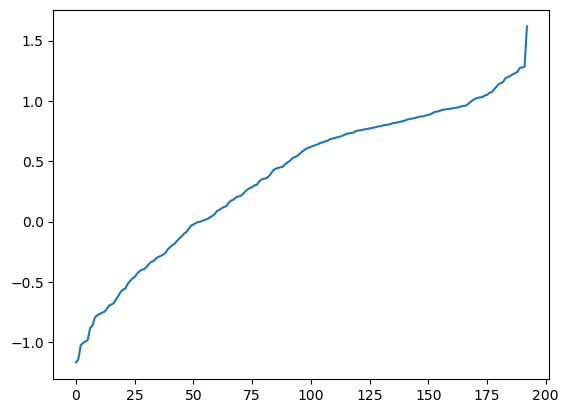

In [50]:
# Find Eigen Values and Eigen vectors of the transition matrix "P"
H = .5*(P + np.transpose(P)) + .5j*(P - np.transpose(P))
w, v = np.linalg.eig(H)  
w = np.real(w)
indsort = np.argsort(w)
w = w[indsort] # Eigen Values
v = v[:, indsort] # Eigen Vectors
plt.plot(w) # Plot eigen values to look at the starting point of the kink 

In [51]:
ncomp = 15 # Keep last "ncomp" eigen vectors
vr = np.multiply(w[-ncomp:], np.real(v[:, -ncomp:]))
vi = np.multiply(w[-ncomp:], np.imag(v[:, -ncomp:]))
vkin = np.append(vr, vi, axis = 1)

In [52]:
def get_kinetic_states(self, vkin, nstates_final, nstates_initial = None, pcut_final = .01,
                       max_states = 20, cluster_ninit = 10):
    if nstates_initial is None:
       nstates_initial = nstates_final
       nstates_good = 0
       nstates = nstates_initial
       while nstates_good < nstates_final and nstates < max_states:
            clusters_v = KMeans(n_clusters = nstates, init = 'k-means++',
                                 n_init = cluster_ninit, max_iter = 1000, 
                                 random_state = 0)
            clusters_v.fit(vkin) 
            stateSet = clusters_v.labels_
            state_probs = np.zeros(nstates)
            statesc,counts = np.unique(stateSet, return_counts = True)
            state_probs[statesc] = counts/np.sum(counts)
            print(np.sort(state_probs))
            nstates_good = np.sum(state_probs > pcut_final)
            print('{} states initial, {} states final'.format(nstates, nstates_good))
            print(nstates, "Current states", nstates_good, "Good states")
            nstates = nstates + 1
       pcut = np.sort(state_probs)[-(nstates_final)] #nstates
       states_plow = np.where(state_probs < pcut)[0]
       # Get rid of the states with probabilities less than 'pcut'
       for i in states_plow:
           indstate = np.where(stateSet == i)[0]
           for imin in indstate:
               dists = wctm.get_dmat(np.array([vkin[imin, :]]), vkin)[0] #closest in eigen space
               dists[indstate] = np.inf
               ireplace = np.argmin(dists)
               stateSet[imin] = stateSet[ireplace]
           slabels, counts = np.unique(stateSet, return_counts = True)
           s = 0
           stateSet_clean = np.zeros_like(stateSet)
           for slabel in slabels:
               indstate = np.where(stateSet == slabel)[0]
               stateSet_clean[indstate] = s
               s = s + 1
           stateSet = stateSet_clean
           if np.max(stateSet) > nstates_final:
              print(f'returning {np.max(stateSet)} states, {nstates_final} requested')
              print("returning ", np.max(stateSet)," states", nstates_final, "requested")
       return stateSet, nstates

In [53]:
get_kstates = True
nstates_final = 7
max_states = 100
stateCenters = clusters_minima.clustercenters
if get_kstates:
   stateSet, nstates = get_kinetic_states(wctm, vkin, nstates_final,
                                          nstates_initial = None, pcut_final = .02, 
                                          max_states = max_states, cluster_ninit = 10)
   # NOTE: pcut_final = 0.2 - 0.25 makes better homogeneous state space occupation, though vary with nstates
   objFile = 'stateSet_'+figid+'_nS'+str(nstates)+'.joblib'
   states_object = [clusters_minima, stateSet]
   with open(objFile, 'wb') as fpStates:
      dump(states_object, fpStates, compress = 'zlib')
else:
   objFile = 'stateSet_'+figid+'_nS'+str(nstates_initial)+'.joblib'
   with open(objFile, 'rb') as fpStates:
       states_object = load(fpStates)
   clusters_minima = states_object[0]
   stateSet = states_object[1]

[0.00518135 0.00518135 0.00518135 0.00518135 0.00518135 0.01554404
 0.95854922]
7 states initial, 1 states final
7 Current states 1 Good states
[0.00518135 0.00518135 0.00518135 0.00518135 0.01036269 0.01554404
 0.01554404 0.93782383]
8 states initial, 1 states final
8 Current states 1 Good states
[0.00518135 0.00518135 0.00518135 0.00518135 0.00518135 0.00518135
 0.01554404 0.02590674 0.92746114]
9 states initial, 2 states final
9 Current states 2 Good states
[0.00518135 0.00518135 0.00518135 0.00518135 0.00518135 0.00518135
 0.00518135 0.01554404 0.02590674 0.92227979]
10 states initial, 2 states final
10 Current states 2 Good states
[0.00518135 0.00518135 0.00518135 0.00518135 0.00518135 0.00518135
 0.00518135 0.01036269 0.01554404 0.01554404 0.92227979]
11 states initial, 1 states final
11 Current states 1 Good states
[0.00518135 0.00518135 0.00518135 0.00518135 0.00518135 0.01036269
 0.01036269 0.01554404 0.01554404 0.02072539 0.04145078 0.86010363]
12 states initial, 3 states fin

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2409: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)


In [54]:
nstates = np.unique(stateSet).size; n_states=nstates
state_centers_minima = np.zeros((n_states, neigen))
for i in range(n_states):
    indstate = np.where(stateSet == i)[0]
    state_centers_minima[i, :] = np.median(stateCenters[indstate, :], axis=0)

state_labels = np.array(list(string.ascii_uppercase))[0:nstates]

In [ ]:
nbins = 100
plt.clf()
plt.figure(figsize = (6, 5))
prob1,xedges1,yedges1 = np.histogram2d(x[:, 0], x[:, 1], bins=nbins, density=True)
prob1 = scipy.ndimage.gaussian_filter(prob1, sigma=2)
xx1,yy1 = np.meshgrid(.5*xedges1[1:] + .5*xedges1[0:-1], .5*yedges1[1:] + .5*yedges1[0:-1])
pts = np.array([xx1.flatten(), yy1.flatten()]).T
indpts = clusters_minima.assign(pts)
states = stateSet[indpts]
states = states[prob1.flatten() > np.min(prob1[prob1 > 0])]
pts = pts[prob1.flatten() > np.min(prob1[prob1 > 0]), :]
plt.contourf(xx1, yy1, prob1.T, cmap=plt.cm.gray_r, levels=20, alpha=.3)
plt.scatter(pts[:,0], pts[:,1], s=10, c=states, cmap=plt.cm.jet, marker='.', alpha=0.5)
plt.scatter(clusters_minima.clustercenters[:, 0], clusters_minima.clustercenters[:, 1],
            s=100, c=stateSet, cmap=plt.cm.jet)

for istate in range(n_states):
    plt.text(state_centers_minima[istate, 0], state_centers_minima[istate, 1], str(state_labels[istate]))

plt.pause(.1)
plt.savefig('kineticstates_'+figid+'_nS_'+str(nstates)+'.png')

<Figure size 640x480 with 0 Axes>

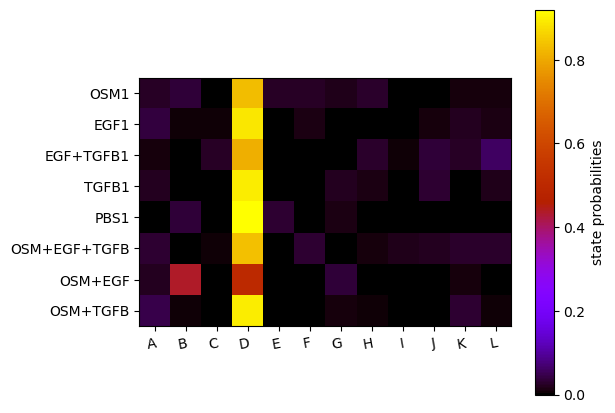

In [55]:
state_probs = np.zeros((nf, n_states))
fl = 72
fu = 120
#fu = nframes
cell_states = clusters_minima
indstw = np.where(np.logical_and(indframes_traj < fu, indframes_traj > fl))[0]
for i in range(nf):
    indstm = inds_conditions[i]
    indstwm = np.intersect1d(indstm, indstw)
    #x0 = x[indstwm, :]
    x0 = Xpcat[indstwm, :]
    indc0 = stateSet[clusters_minima.assign(x0)]
    statesc,counts = np.unique(indc0, return_counts=True)
    state_probs[i, statesc] = counts/np.sum(counts)

state_order = np.arange(n_states).astype(int)
plt.clf()
plt.figure(figsize = (6, 5))
plt.imshow(state_probs[:, state_order], cmap=plt.cm.gnuplot)
cbar = plt.colorbar()
cbar.set_label('state probabilities')
# We want to show all ticks...
ax = plt.gca()
ax.set_yticks(np.arange(len(tmSet)))
ax.set_xticks(np.arange(nstates))
ax.set_xticklabels(np.array(state_labels)[state_order])
ax.set_yticklabels(tmSet)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=10, ha="right",rotation_mode="anchor")
plt.pause(.1);

#plt.savefig('stateprobs_'+figid+'_nS_'+str(nstates)+'.png')
#np.savetxt('stateprobs_'+figid+'_nS'+str(nstates)+'.dat',state_probs)
plt.show()

In [ ]:
states_x = stateSet[cell_states.assign(x)]
inds_states = [None]*n_states
for i in range(n_states):
    indstate = np.where(states_x == i)[0]
    inds_states[i] = indstate

vset = Xpcat[:, -3]
plt.clf()
ax = plt.gca()
#vset = np.log2(cc_ratio_traj)
for i in range(n_states):
    ii = state_order[i]
    vplot = ax.violinplot(vset[inds_states[ii]], positions=[i+1],
                          showmeans=True, showextrema=False) #,quantiles=[.05,.95])
    vplot['cmeans'].set_color('black')
    for pc in vplot['bodies']:
        pc.set_facecolor('black')
        #pc.set_edgecolor('black')
        #pc.set_alpha(1)
    plt.pause(.1)

ax.set_xticks(range(1, n_states+1))
ax.set_xticklabels(np.array(state_labels)[state_order])
#plt.ylabel('log2(nuc/cyto cc-ratio)')
#plt.ylabel(r'cell-cell local alignment $\langle \hat{v}_1 \cdot \hat{v}_2 \rangle$')
#plt.ylabel('speed (z-score)')
plt.ylabel('speed (z-score)')
plt.xlabel('states')
plt.pause(.1)
plt.savefig('speed_'+figid+'.png')

In [ ]:
from adjustText import adjust_text

istate=5
indcells_traj=inds_states[istate]
indmodels=indtreatment_traj[indcells_traj]
indcells_model=cellinds1_traj[indcells_traj]
for ic in [100,500,1000,1500,2000]: #range(indcells_traj.size):
    model_sctm=modelSet[indgood_models[indmodels[ic]]]
    celltraj=model_sctm.get_cell_trajectory(indcells_model[ic])
    model_sctm.visual=True
    model_sctm.show_cells(celltraj)
    plt.pause(1)
    plt.savefig('cell'+str(ic)+'_state'+str(istate)+'_'+figid+'.png')